In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from toygrad import MLP, Layer, Sigmoid, SoftMax, ReLU, TanH, Linear, SquaredError, CategoricalCrossEntropy, Accuracy, get_metric_key
from plot import plot_network, plot_metric

np.random.seed(2137)
plt.rcParams["figure.figsize"] = (20,20)

TRAINING_DATASET = "data/mnist/train.csv"
TESTING_DATASET = "data/mnist/test.csv"

def one_hot(y):
    y = y.astype(int)
    encoded = np.zeros((y.size, y.max()+1))
    encoded[np.arange(y.size), y.reshape(1, -1)] = 1
    return encoded

def read_mnist(path):
    """Read and shuffle the dataset"""
    data = np.genfromtxt(path, delimiter=',')[1:]
    np.random.shuffle(data)
    X = data[:, 1:]
    Y = one_hot(data[:, 0].reshape(-1, 1))
    return X, Y

def read_test(path):
    X = np.genfromtxt(path, delimiter=',')[1:]
    return X
    

def plot_images(X):
    # Disregard elements which would not fit in square
    size = int(len(X)**(1/2))
    x = X[:size**2]
    plt.imshow(np.concatenate(x.reshape(size, size*28, 28), axis=1))
    plt.show()
    
def transform(X):
    # Mean and Std are calculated directly on whole X set
    x = X/255
    x = (x-0.13101)/0.3085
    return x
    
X, Y = read_mnist(TRAINING_DATASET)

train_size = int(len(X)*0.8)

X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

# Initial training - simple architecture

Epoch    1
 Accuracy_train: 0.106
 Accuracy_test: 0.115
 CategoricalCrossEntropy_train: 2.433
 CategoricalCrossEntropy_train_std: 0.428
 CategoricalCrossEntropy_test: 2.302
 CategoricalCrossEntropy_test_std: 0.070
Epoch    2
 Accuracy_train: 0.104
 Accuracy_test: 0.115
 CategoricalCrossEntropy_train: 2.303
 CategoricalCrossEntropy_train_std: 0.068
 CategoricalCrossEntropy_test: 2.302
 CategoricalCrossEntropy_test_std: 0.070
Epoch    3
 Accuracy_train: 0.104
 Accuracy_test: 0.115
 CategoricalCrossEntropy_train: 2.303
 CategoricalCrossEntropy_train_std: 0.068
 CategoricalCrossEntropy_test: 2.302
 CategoricalCrossEntropy_test_std: 0.070
Epoch    4
 Accuracy_train: 0.104
 Accuracy_test: 0.115
 CategoricalCrossEntropy_train: 2.303
 CategoricalCrossEntropy_train_std: 0.068
 CategoricalCrossEntropy_test: 2.302
 CategoricalCrossEntropy_test_std: 0.070
Epoch    5
 Accuracy_train: 0.104
 Accuracy_test: 0.115
 CategoricalCrossEntropy_train: 2.303
 CategoricalCrossEntropy_train_std: 0.068
 Categor

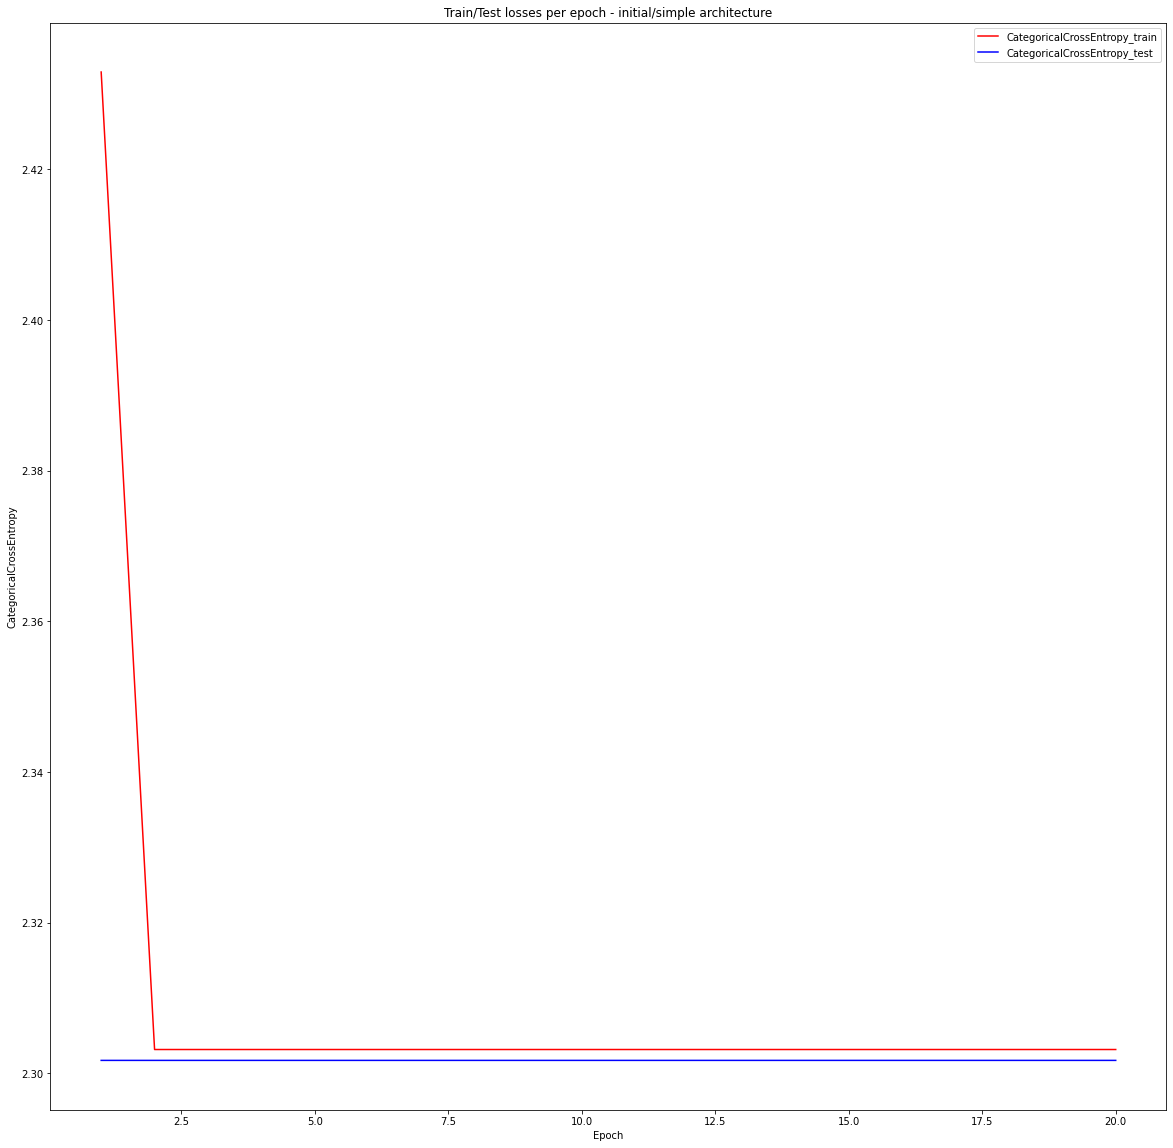

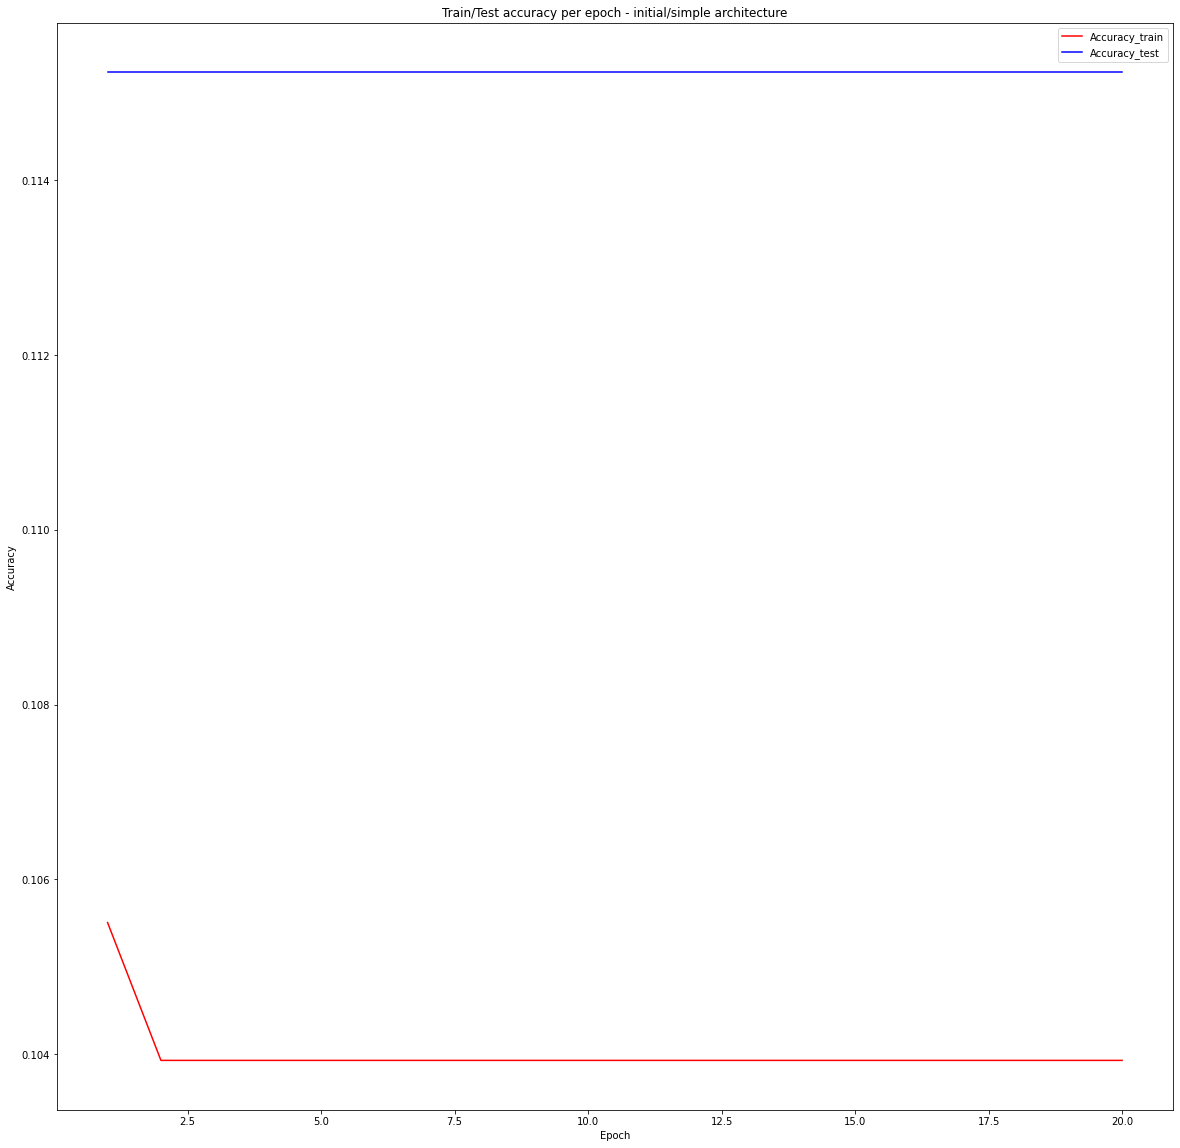

CPU times: user 15min 44s, sys: 35min 48s, total: 51min 33s
Wall time: 6min 58s


In [3]:
%%time
layers = [
    Layer(in_size=28*28, out_size=32, activ_function=Sigmoid),
    Layer(in_size=32, out_size=10, activ_function=SoftMax),
]

m = MLP(
    layers=layers,
    loss=CategoricalCrossEntropy,
    metrics=[Accuracy],
    bias=True,
    batch_size=8,
    epochs=20,
    momentum=0.,
    learning_rate=0.3,
    verbosity=2,
)
stats = m.train(X_train, Y_train, X_test, Y_test)
plot_metric(m.loss, stats, title="Train/Test losses per epoch - initial/simple architecture")
plot_metric(Accuracy(), stats, title="Train/Test accuracy per epoch - initial/simple architecture")

# Adding normalisation - simple architecture

Epoch    1
 Accuracy_train: 0.103
 Accuracy_test: 0.115
 CategoricalCrossEntropy_train: 2.847
 CategoricalCrossEntropy_train_std: 1.268
 CategoricalCrossEntropy_test: 2.575
 CategoricalCrossEntropy_test_std: 1.008
Epoch    2
 Accuracy_train: 0.104
 Accuracy_test: 0.115
 CategoricalCrossEntropy_train: 2.376
 CategoricalCrossEntropy_train_std: 0.329
 CategoricalCrossEntropy_test: 2.302
 CategoricalCrossEntropy_test_std: 0.070
Epoch    3
 Accuracy_train: 0.104
 Accuracy_test: 0.115
 CategoricalCrossEntropy_train: 2.303
 CategoricalCrossEntropy_train_std: 0.068
 CategoricalCrossEntropy_test: 2.302
 CategoricalCrossEntropy_test_std: 0.070
Epoch    4
 Accuracy_train: 0.104
 Accuracy_test: 0.115
 CategoricalCrossEntropy_train: 2.303
 CategoricalCrossEntropy_train_std: 0.068
 CategoricalCrossEntropy_test: 2.302
 CategoricalCrossEntropy_test_std: 0.070
Epoch    5
 Accuracy_train: 0.104
 Accuracy_test: 0.115
 CategoricalCrossEntropy_train: 2.303
 CategoricalCrossEntropy_train_std: 0.068
 Categor

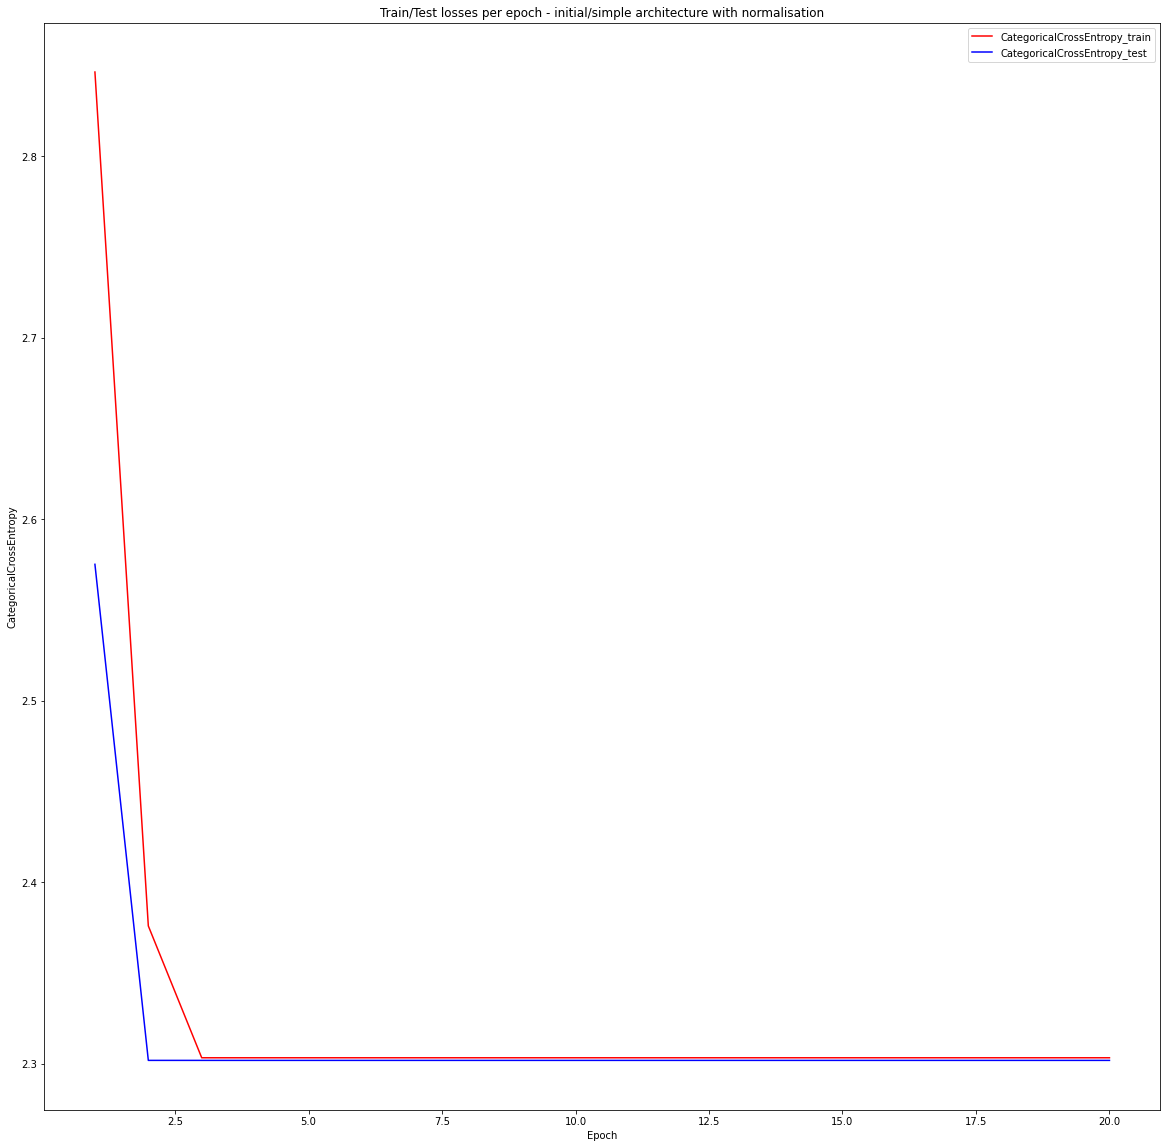

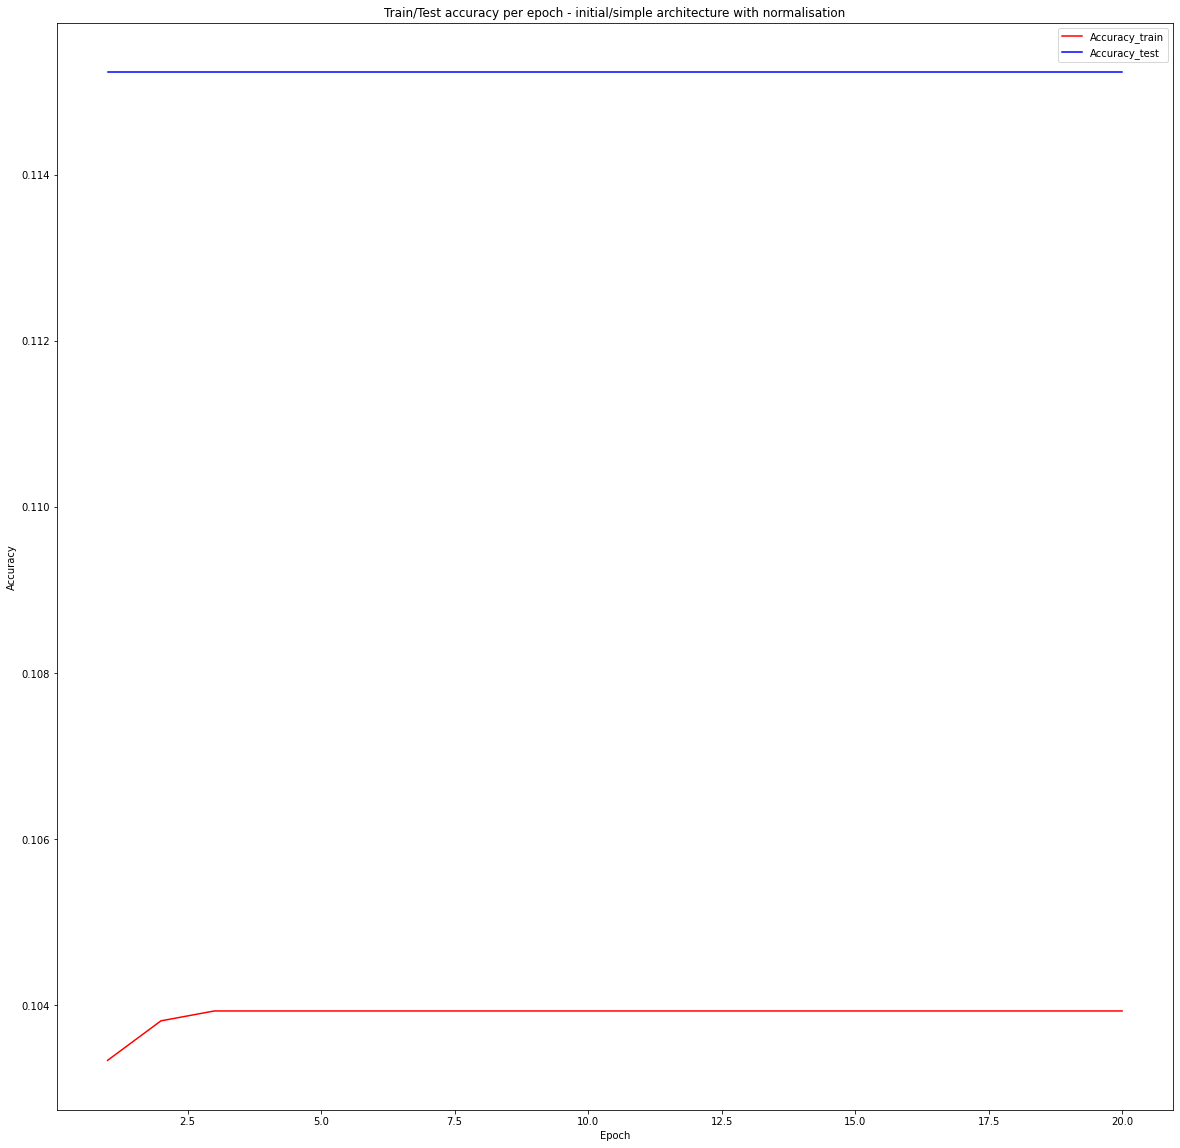

CPU times: user 16min 44s, sys: 37min 32s, total: 54min 17s
Wall time: 7min 23s


In [4]:
%%time
X = transform(X)
layers = [
    Layer(in_size=28*28, out_size=32, activ_function=Sigmoid),
    Layer(in_size=32, out_size=10, activ_function=SoftMax),
]
m = MLP(
    layers=layers,
    loss=CategoricalCrossEntropy,
    metrics=[Accuracy],
    bias=True,
    batch_size=8,
    epochs=20,
    momentum=0.,
    learning_rate=0.3,
    verbosity=2,
)
stats = m.train(X_train, Y_train, X_test, Y_test)
plot_metric(m.loss, stats, title="Train/Test losses per epoch - initial/simple architecture with normalisation")
plot_metric(Accuracy(), stats, title="Train/Test accuracy per epoch - initial/simple architecture with normalisation")

## Automated parameter optimization

In [ ]:
%%time
activations = [Sigmoid, ReLU, TanH]
layer_sizes = [32, 64, 128, 256]
layer_numbers = [1, 2, 3]
learning_rates = [0.5, 0.4, 0.3, 0.2, 0.1]
def save_results_df(result, name="hyperparamter_results.csv"):  
    results_df = pd.DataFrame(result)
    results_df = results_df.sort_values('test_accuracy', ascending=False)
    results_df.to_csv(name)
    return results_df
    
epochs = 20
result = {
    "activation": [],
    "layer_size": [],
    "hidden_layer_number": [],
    "learning_rate": [],
    "epochs": [],
    "test_accuracy": [],
    "train_loss": [],
    "train_loss_std": [],
}
for activation in activations:
    for size in layer_sizes:
        for layer_num in layer_numbers:
            for lr in learning_rates:
                print("===================================================================================")
                header = f"Layer number: {layer_num}, Layer size: {size}, Activation: {str(activation())}, Learning rate: {lr}"
                result["activation"].append(activation())
                result["layer_size"].append(size)
                result["learning_rate"].append(lr)
                result["hidden_layer_number"].append(layer_num)
                result["epochs"].append(epochs)
                print(header)
                print("===================================================================================")
                layers = [
                    Layer(in_size=28*28, out_size=size, activ_function=activation),
                    *[Layer(in_size=size, out_size=size, activ_function=activation) for _ in range(layer_num-1)],
                    Layer(in_size=size, out_size=10, activ_function=SoftMax),
                ]
                m = MLP(
                    layers=layers,
                    loss=CategoricalCrossEntropy,
                    metrics=[Accuracy],
                    bias=True,
                    batch_size=4,
                    epochs=20,
                    momentum=0,
                    learning_rate=lr,
                    verbosity=1,
                )
                stats = m.train(X_train, Y_train, X_test, Y_test)
                plot_metric(m.loss, stats, title=f"Train/Test losses per epoch - {header}")
                plot_metric(Accuracy(), stats, title=f"Train/Test accuracy per epoch - {header}")
                
                result["test_accuracy"].append(stats[get_metric_key(Accuracy(), "test")][-1])
                result["train_loss"].append(stats[get_metric_key(m.loss, "train")][-1])
                result["train_loss_std"].append(stats[get_metric_key(m.loss, "train_std")][-1])
                result_df = save_results_df(result)
                display(result_df)
result_df

# Optimizing numbers of neurons in top architecture

In [ ]:
%%time
activations = [TanH]
layer_sizes = [256, 512, 1024]
layer_numbers = [1]
learning_rates = [0.4]
epochs = 20
result = {
    "activation": [],
    "layer_size": [],
    "hidden_layer_number": [],
    "learning_rate": [],
    "epochs": [],
    "test_accuracy": [],
    "train_loss": [],
    "train_loss_std": [],
}
for activation in activations:
    for size in layer_sizes:
        for layer_num in layer_numbers:
            for lr in learning_rates:
                print("===================================================================================")
                header = f"Layer number: {layer_num}, Layer size: {size}, Activation: {str(activation())}, Learning rate: {lr}"
                result["activation"].append(activation())
                result["layer_size"].append(size)
                result["learning_rate"].append(lr)
                result["hidden_layer_number"].append(layer_num)
                result["epochs"].append(epochs)
                print(header)
                print("===================================================================================")
                layers = [
                    Layer(in_size=28*28, out_size=size, activ_function=activation),
                    *[Layer(in_size=size, out_size=size, activ_function=activation) for _ in range(layer_num-1)],
                    Layer(in_size=size, out_size=10, activ_function=SoftMax),
                ]
                m = MLP(
                    layers=layers,
                    loss=CategoricalCrossEntropy,
                    metrics=[Accuracy],
                    bias=True,
                    batch_size=4,
                    epochs=20,
                    momentum=0.1,
                    learning_rate=lr,
                    verbosity=1,
                )
                stats = m.train(X_train, Y_train, X_test, Y_test)
                plot_metric(m.loss, stats, title=f"Train/Test losses per epoch - {header}")
                plot_metric(Accuracy(), stats, title=f"Train/Test accuracy per epoch - {header}")
                
                result["test_accuracy"].append(stats[get_metric_key(Accuracy(), "test")][-1])
                result["train_loss"].append(stats[get_metric_key(m.loss, "train")][-1])
                result["train_loss_std"].append(stats[get_metric_key(m.loss, "train_std")][-1])
                result_df = save_results_df(result, name="optimal_solution_layer_sizes.csv")
                display(result_df)
result_df

# Final training of the solution

In [ ]:
%%time
layers = [
    Layer(in_size=28*28, out_size=256, activ_function=TanH),
    Layer(in_size=256, out_size=10, activ_function=SoftMax),
]
m = MLP(
    layers=layers,
    loss=CategoricalCrossEntropy,
    metrics=[Accuracy],
    bias=True,
    batch_size=8,
    epochs=100,
    momentum=0.1,
    learning_rate=0.4,
    verbosity=2,
)
stats = m.train(X_train, Y_train, X_test, Y_test)
plot_metric(m.loss, stats, title="Train/Test losses per epoch - best hyperparameter network.")
plot_metric(Accuracy(), stats, title="Train/Test accuracy per epoch - best hyperparameter network.")

# Additional low learning rate training

In [ ]:
%%time
m.learning_rate = 0.01
m.momentum = 0
m.epochs = 15
stats = m.train(X_train, Y_train, X_test, Y_test)
plot_metric(m.loss, stats, title="Train/Test losses per epoch - best hyperparameter network with decreased lr")
plot_metric(Accuracy(), stats, title="Train/Test accuracy per epoch - best hyperparameter network with decreased lr")

# Making predictions of the Kaggle dataset

In [ ]:
X_kaggle_test = read_test(TEST_DATASET)
preds = m.predict(X_kaggle_test)
print(preds)